<a href="https://colab.research.google.com/github/LivioXie/ICSI435_Group/blob/main/GAN_proto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Generator Loss: 0.6682760119438171, Discriminator Loss: 0.7595512270927429
Epoch 2, Generator Loss: 0.6939330101013184, Discriminator Loss: 0.7123901844024658
Epoch 3, Generator Loss: 0.7252665758132935, Discriminator Loss: 0.6770473718643188
Epoch 4, Generator Loss: 0.7761558890342712, Discriminator Loss: 0.6296278834342957
Epoch 5, Generator Loss: 0.836067795753479, Discriminator Loss: 0.5805301666259766
Epoch 6, Generator Loss: 0.9056620597839355, Discriminator Loss: 0.5300789475440979
Epoch 7, Generator Loss: 0.9908950924873352, Discriminator Loss: 0.4747239351272583
Epoch 8, Generator Loss: 1.106212854385376, Discriminator Loss: 0.4104393422603607
Epoch 9, Generator Loss: 1.2512696981430054, Discriminator Loss: 0.3442615866661072
Epoch 10, Generator Loss: 1.4259331226348877, Discriminator Loss: 0.28110212087631226
Epoch 11, Generator Loss: 1.6313765048980713, Discriminator Loss: 0.22327832877635956
Epoch 12, Generator Loss: 1.8518918752670288, Discriminator Loss: 0.175232

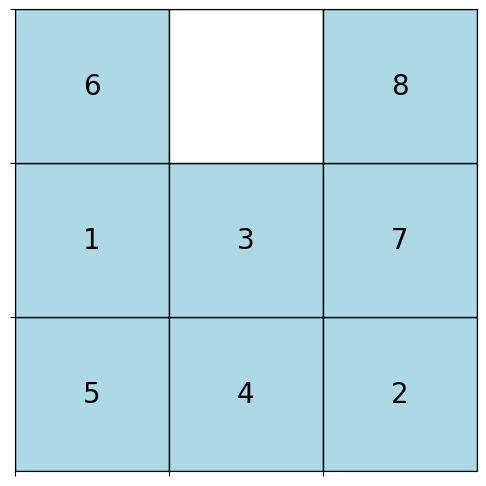

Epoch 101, Generator Loss: 8.085693359375, Discriminator Loss: 0.00031341638532467186
Epoch 102, Generator Loss: 8.10964584350586, Discriminator Loss: 0.0003059276205021888
Epoch 103, Generator Loss: 8.138946533203125, Discriminator Loss: 0.00029710622038692236
Epoch 104, Generator Loss: 8.169694900512695, Discriminator Loss: 0.0002881588297896087
Epoch 105, Generator Loss: 8.191156387329102, Discriminator Loss: 0.0002819380024448037
Epoch 106, Generator Loss: 8.226032257080078, Discriminator Loss: 0.0002723191864788532
Epoch 107, Generator Loss: 8.262280464172363, Discriminator Loss: 0.00026270310627296567
Epoch 108, Generator Loss: 8.277080535888672, Discriminator Loss: 0.000258721353020519
Epoch 109, Generator Loss: 8.306526184082031, Discriminator Loss: 0.0002512221981305629
Epoch 110, Generator Loss: 8.332623481750488, Discriminator Loss: 0.0002447469742037356
Epoch 111, Generator Loss: 8.369613647460938, Discriminator Loss: 0.00023592566139996052
Epoch 112, Generator Loss: 8.3919

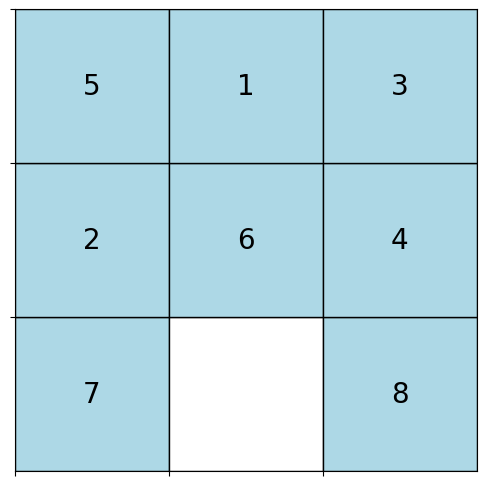

Epoch 201, Generator Loss: 10.45969009399414, Discriminator Loss: 2.9113747586961836e-05
Epoch 202, Generator Loss: 10.480929374694824, Discriminator Loss: 2.8507663955679163e-05
Epoch 203, Generator Loss: 10.500507354736328, Discriminator Loss: 2.795399268507026e-05
Epoch 204, Generator Loss: 10.515851020812988, Discriminator Loss: 2.752473665168509e-05
Epoch 205, Generator Loss: 10.544710159301758, Discriminator Loss: 2.6752033591037616e-05
Epoch 206, Generator Loss: 10.560820579528809, Discriminator Loss: 2.631977440614719e-05
Epoch 207, Generator Loss: 10.583162307739258, Discriminator Loss: 2.573906022007577e-05
Epoch 208, Generator Loss: 10.602678298950195, Discriminator Loss: 2.524311094020959e-05
Epoch 209, Generator Loss: 10.622820854187012, Discriminator Loss: 2.473689164617099e-05
Epoch 210, Generator Loss: 10.641284942626953, Discriminator Loss: 2.428190600767266e-05
Epoch 211, Generator Loss: 10.660959243774414, Discriminator Loss: 2.380781006650068e-05
Epoch 212, Generato

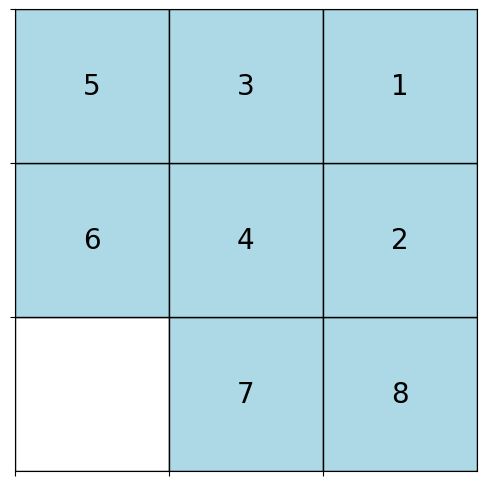

Epoch 301, Generator Loss: 12.441572189331055, Discriminator Loss: 4.017569153802469e-06
Epoch 302, Generator Loss: 12.459314346313477, Discriminator Loss: 3.945718162867706e-06
Epoch 303, Generator Loss: 12.474961280822754, Discriminator Loss: 3.8847042560519185e-06
Epoch 304, Generator Loss: 12.493180274963379, Discriminator Loss: 3.814421233983012e-06
Epoch 305, Generator Loss: 12.51434326171875, Discriminator Loss: 3.7353472635004437e-06
Epoch 306, Generator Loss: 12.528667449951172, Discriminator Loss: 3.6818817079620203e-06
Epoch 307, Generator Loss: 12.551039695739746, Discriminator Loss: 3.6011622341902694e-06
Epoch 308, Generator Loss: 12.575325012207031, Discriminator Loss: 3.515381877150503e-06
Epoch 309, Generator Loss: 12.597687721252441, Discriminator Loss: 3.4388244785077404e-06
Epoch 310, Generator Loss: 12.602252960205078, Discriminator Loss: 3.420886059757322e-06
Epoch 311, Generator Loss: 12.628772735595703, Discriminator Loss: 3.332281949042226e-06
Epoch 312, Genera

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
import matplotlib.pyplot as plt

# Constants
PUZZLE_SIZE = 3  # 3x3 puzzle
SEED_SIZE = 100
EPOCHS = 1000
BATCH_SIZE = 32

# Generate random 3x3 sliding puzzle configurations
def generate_puzzle_batch(batch_size):
    puzzles = []
    for _ in range(batch_size):
        puzzle = np.arange(PUZZLE_SIZE * PUZZLE_SIZE)
        np.random.shuffle(puzzle)
        puzzle = puzzle.reshape((PUZZLE_SIZE, PUZZLE_SIZE))
        puzzles.append(puzzle)
    return np.array(puzzles)

# Generator
def build_generator(seed_size):
    model = Sequential()
    model.add(Dense(128, input_dim=seed_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(PUZZLE_SIZE * PUZZLE_SIZE, activation='softmax'))  # Output is a probability distribution
    model.add(Reshape((PUZZLE_SIZE, PUZZLE_SIZE)))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(PUZZLE_SIZE, PUZZLE_SIZE)))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1, activation='sigmoid'))
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Build models
generator = build_generator(SEED_SIZE)
discriminator = build_discriminator()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

# Training step
@tf.function
def train_step(puzzles):
    noise = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_puzzles = generator(noise, training=True)

        real_output = discriminator(puzzles, training=True)
        fake_output = discriminator(generated_puzzles, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for puzzle_batch in dataset:
            gen_loss, disc_loss = train_step(puzzle_batch)

        # Print progress
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")

        # Generate and save a sample puzzle
        if (epoch + 1) % 100 == 0:
            sample_puzzle(generator)

# Function to sample a generated puzzle and plot
def sample_puzzle(generator_model):
    noise = tf.random.normal([1, SEED_SIZE])
    generated_puzzle = generator_model(noise, training=False).numpy().reshape((PUZZLE_SIZE, PUZZLE_SIZE))

    # Convert the generated puzzle to a valid permutation of numbers 0 to 8
    generated_puzzle = np.argsort(generated_puzzle.flatten())  # Ensure it's a valid permutation
    generated_puzzle = generated_puzzle.reshape((PUZZLE_SIZE, PUZZLE_SIZE))

    print("Generated Puzzle:")
    print(generated_puzzle)

    # Plot with labels
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(PUZZLE_SIZE):
        for j in range(PUZZLE_SIZE):
            num = int(generated_puzzle[i, j])  # Convert to int to display as a number
            color = 'lightblue' if num != 0 else 'white'  # Set color for blank space (0)
            ax.add_patch(plt.Rectangle((j, PUZZLE_SIZE-i-1), 1, 1, facecolor=color, edgecolor='black'))

            if num != 0:  # Only add number to non-zero cells
                ax.text(j + 0.5, PUZZLE_SIZE-i-0.5, str(num), color='black', ha='center', va='center', fontsize=20)

    ax.set_xlim(0, PUZZLE_SIZE)
    ax.set_ylim(0, PUZZLE_SIZE)
    ax.set_xticks(np.arange(0, PUZZLE_SIZE, 1))
    ax.set_yticks(np.arange(0, PUZZLE_SIZE, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()  # To match typical 2D array coordinates where the origin is top-left
    plt.show()

# Generate dataset and train
puzzle_data = generate_puzzle_batch(1000)
puzzle_dataset = tf.data.Dataset.from_tensor_slices(puzzle_data).batch(BATCH_SIZE)

train(puzzle_dataset, EPOCHS)
